In [3]:
import ast
import json
import math
from os import path
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  
import seaborn as sns
import numpy as np
from Bio import SeqIO

# Figure 3: Rates of adaptation across the genomes of a diverse range of human pathogenic viruses

Plot the estimated rate of adaptation in all genes of the genome, for a handful of viruses, spanning different viral families, genome types and transmission modes

In [4]:
def readin_virus_config(virus):
    config_json = f'config/adaptive_evo_config_{virus}.json'

    with open(config_json) as json_handle:
        configs = json.load(json_handle)
        
    return configs

In [83]:
def get_rates(virus_and_subtype):
    """
    Get rates of adaptation for each gene in the genome
    Return rates and 95CIs given in adaptive muts per codon per year x10-3
    """
    
    rates_by_gene = {}
    
    if 'dengue' in virus_and_subtype:
        virus = 'dengue'
        subtype = 'denv'+virus_and_subtype.split('dengue')[1]
        virus_and_subtype = 'dengue_'+subtype
    elif 'hepatitisA' in virus_and_subtype:
        virus = virus_and_subtype
        subtype=None
    else:
        if '_' in virus_and_subtype:
            virus = virus_and_subtype.split('_')[0]
            subtype = virus_and_subtype.split('_')[1]
        else:
            virus = virus_and_subtype
            subtype = None
    
    configs = readin_virus_config(virus)
    genes = configs['genes']
    
    for gene in genes:
        bhatt_json_name = f'bhatt_results_nextstrain/{virus_and_subtype}_{gene}_bhatt_analysis_bootstrapped.json'
        if path.exists(bhatt_json_name):
            with open(bhatt_json_name) as bhatt_handle:
                json_dict = json.load(bhatt_handle)
                (bhatt_window_midpoint, bhatt_adaptive_substitutions, 
                 bhatt_adaptive_substitutions_per_codon, 
                 bhatt_rate_of_adaptation, bhatt_bootstrap_adaptive_substitutions, 
                 bhatt_bootstrap_adaptive_substitutions_per_codon, 
                 bhatt_bootstrap_rate_of_adaptation) = (json_dict['window_midpoint'], 
                                                  json_dict['adaptive_substitutions'], 
                                                  json_dict['adaptive_substitutions_per_codon'], 
                                                  json_dict['rate_of_adaptation'], 
                                                  json_dict['bootstrap_adaptive_substitutions'], 
                                                  json_dict['bootstrap_adaptive_substitutions_per_codon'], 
                                                  json_dict['bootstrap_rate_of_adaptation'])
                
            bs_slope_sci = [x * (10**3) for x in bhatt_bootstrap_rate_of_adaptation]
            lower_95ci = np.percentile(sorted(bs_slope_sci), 2.5)
            upper_95ci = np.percentile(sorted(bs_slope_sci), 97.5)
        if 'rotavirus' in virus_and_subtype:
            rota_segment_to_gene = {'A':'NSP1', 'C':'VP2', 'E':'NSP4', 'G':'VP7', 'I':'VP6', 
                            'M': 'VP3', 'N': 'NSP2', 'P':'VP4', 'R':'VP1', 'T':'NSP3'}
            rates_by_gene[rota_segment_to_gene[gene]] = {'rate':bhatt_rate_of_adaptation* (10**3), 'upper_95ci':upper_95ci, 
                                   'lower_95ci':lower_95ci}

        else:
            rates_by_gene[gene.upper()] = {'rate':bhatt_rate_of_adaptation* (10**3), 'upper_95ci':upper_95ci, 
                                   'lower_95ci':lower_95ci}

    
    return rates_by_gene

In [91]:
def x_coordinates(virus):
    """
    For all genes where rate of adaptation was calculated,
    Return the X position to plot the rate (so genes are shown in genome order). 
    Normalize all x-coordates to a total length of 8
    """
    
    configs = readin_virus_config(virus)
    genes = configs['genes']
    #order genes based on segment numbering
    if virus in ['h3n2', 'h1n1pdm', 'vic', 'yam']:
        genes = ['PB2', 'PB1', 'PA', 'ha1', 'ha2', 'NP', 'NA']
    if virus=='influenzaC':
        genes = ['PB2', 'PB1', 'P3','HEF1', 'HEF2', 'NP', 'M', 'NS']
    if 'rotavirus' in virus:
        rota_segment_to_gene = {'A':'NSP1', 'C':'VP2', 'E':'NSP4', 'G':'VP7', 'I':'VP6', 
                        'M': 'VP3', 'N': 'NSP2', 'P':'VP4', 'R':'VP1', 'T':'NSP3'}
        genes = [rota_segment_to_gene[g] for g in genes]
        
    space_between_genes = 8/(len(genes)-1)

    gene_x_positions = {}
    
    last_coord = 0
    for gene in genes:
        gene_x_positions[gene.upper()] = last_coord
        last_coord+=space_between_genes
    
    gene_labels = [g.upper() for g in genes]

    gene_labels = [legible_gene_titles[g] if g in legible_gene_titles.keys() else g for g in gene_labels]
    
    
    return gene_x_positions, gene_labels

In [74]:
#make gene names more legible
legible_gene_titles = {'PROTEIN4A': 'Protein 4A', 'PROTEIN4B': 'Protein 4B', 'PROTEIN3':'Protein 3', 'RDRP': 'RdRp', 
                       'POLYMERASE': 'Polymerase', 'LARGE':'Large', 'MIDDLE':'Middle', 
                       'SMALL':'Small', 'CORE':'Core', 'PROTEASE':'Protease', 
                       'PENTON':'Penton', 'HEXON':'Hexon', 'FIBER': 'Fiber'}


In [81]:
#make the virus name more legible
legible_titles_viruses = {'rsv_A': 'RSV-A', 'rsv_B': 'RSV-B', 
                         '229e': 'Coronavirus 229E', 'oc43_A': 'Coronavirus OC43-A', 
                         'oc43_B': 'Coronavirus OC43-B', 'nl63': 'Coronavirus NL63', 
                          'measles': 'Measles', 'h3n2': 'Influenza A/H3N2', 
                          'vic': 'Influenza B/Vic', 'yam': 'Influenza B/Yam',
                          'influenzaC_Yamagata': 'Influenza C/Yamagata',
                          'enterovirusd68': 'Enterovirus D68', 'norovirus': 'Norovirus GII.4', 
                          'hepatitisB_A2':'HepatitisB-A2', 'dengue4_II': 'Dengue 4-II',
                          'hepatitisB_C':'hepatitisB-C','hepatitisB_D3':'HepatitisB-D3', 
                          'hepatitisA_IA': 'Hepatitis A-IA', 'hepatitisA_IB': 'Hepatitis A-IB', 
                          'rotavirusAg1p8': 'Rotavirus A/P[8]',
                          'adenovirusB7': 'Adenovirus B-7'}

In [80]:
#additional info for each virus
additional_info = {'h3n2': 'Orthomyxovirus \n- sense RNA, segmented \nEnveloped', 
                   'influenzaC': 'Orthomyxovirus \n- sense RNA, segmented \nEnveloped', 
                   'measles': 'Paramyxovirus \n- sense RNA \nEnveloped', 
                   'rsv': 'Paramyxovirus \n- sense RNA \nEnveloped', 
                   '229e': 'Coronavirus \n+ sense RNA \nEnveloped', 
                   'nl63': 'Coronavirus \n+ sense RNA \nEnveloped', 
                   'dengue': 'Flavivirus \n+ sense RNA \nEnveloped', 
                   'enterovirusd68': 'Picornavirus \n+ sense RNA \nNon-enveloped', 
                   'hepatitisA_IA': 'Picornavirus \n+ sense RNA \nNon-enveloped', 
                   'rotavirusAg1p8': 'Reovirus \ndsRNA, segmented \nNon-enveloped',
                   'hepatitisB': 'Hepadnavirus \nPartially dsDNA, circular \nEnveloped', 
                   'adenovirusB7': 'Adenovirus \ndsDNA \nNon-enveloped'}


In [79]:
#for each virus label which protein binds receptors
receptor_binder = {'h3n2': 'HA1', 'influenzaC':'HEF1', 'measles': 'H', '229e':'S1', 'nl63':'S1',
                   'dengue':'E', 'rsv':'G',
                   'enterovirusd68':'VP1', 'hepatitisA_IA':'VP1', 'rotavirusAg1p8': 'VP4',
                   'hepatitisB':'Large', 'adenovirusB7':'Fiber'}


In [94]:
#for each virus label surface proteins that are not receptor-biding
other_surface = {'h3n2': ['HA2', 'NA'], 'influenzaC': ['HEF2'], 'measles': ['F'], '229e':['S2'], 'nl63':['S2'],
                   'dengue':[], 'rsv': ['F', 'SH'],
                   'enterovirusd68':['VP2', 'VP3'], 'hepatitisA_IA':['VP2', 'VP3'], 'rotavirusAg1p8': ['VP7'],
                   'hepatitisB':['Small', 'Middle'], 'adenovirusB7':['Penton','Hexon']}

In [96]:
def plot_rate_on_genome_cartoon(viruses, filename=False):
    """
    For each virus, plot a cartoon of it's genome (or at least of the parts where rates were calculated)
    Above the cartoon, plot the rate of adaptation in this gene
    """
    
    num_rows_to_plot = int(round(len(viruses)/2))
    
    #plot styling
    sns.set_style("white")
    plt.rcParams['axes.labelsize'] = 10
    plt.rcParams['axes.labelweight'] = 'normal'
    plt.rcParams['axes.titlesize'] = 12
    plt.rcParams['xtick.labelsize'] = 10
    plt.rcParams['ytick.labelsize'] = 12
    plt.rcParams['legend.fontsize'] = 8
    plt.rcParams['figure.dpi']= 300
    
    #initiate plot with one axis per virus
    fig, axs = plt.subplots(num_rows_to_plot, 2, figsize=(8,2.5*(num_rows_to_plot)), sharey=True)
    
    #figure panel labels
    fig_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
    
    #line/edge color by virus
    linecolor = {'h3n2': '#4C1320', 'influenzaC': '#9f0050', 'measles': '#ed520e', 'rsv': '#4c5267',
                 '229e':'#3f988f', 'nl63':'#84ceac','dengue':'#4dd3f4', 
                 'enterovirusd68':'#704d9d', 'hepatitisA_IA':'#904782', 'rotavirusAg1p8': '#101064',
                 'hepatitisB':'#ffba89', 'adenovirusB7':'#e63900'}
    
    
    #make a subplot for each virus
    for v in range(len(viruses)):
        virus_and_subtype = viruses[v]
        
        if 'dengue' in virus_and_subtype:
            virus = 'dengue'
            subtype = 'denv'+virus_and_subtype.split('dengue')[1]
        elif 'hepatitisA' in virus_and_subtype:
            virus = virus_and_subtype
            subtype=None
        else:
            if '_' in virus_and_subtype:
                virus = virus_and_subtype.split('_')[0]
                subtype = virus_and_subtype.split('_')[1]
            else:
                virus = virus_and_subtype
                subtype = None
        
        configs = readin_virus_config(virus)
        if subtype:
            color = configs['color'][subtype]
        else:
            color= configs['color']

        #get axis coordinates
        j=0
        if v%2!=0:
            j = 1
        i = math.floor(v/2)
        fig_index = 2*i+j
        
        #add figure panel labels
        axs[i, j].text(-0.1, 1.0, fig_labels[fig_index], horizontalalignment='center', 
                       verticalalignment='center', weight='bold', fontsize=16, transform=axs[i, j].transAxes)
        
        #get rates of adaptation for each gene in this virus
        rates_by_gene = get_rates(virus_and_subtype)
        
        #get x-positions for genes
        gene_x_pos, gene_labels = x_coordinates(virus)

        
        x_ticks = []
        for gene, rates in rates_by_gene.items():
            rate = rates['rate']
            err_lower = rates['lower_95ci']
            err_upper = rates['upper_95ci']
            
            x_pos = gene_x_pos[gene]
            x_ticks.append(x_pos)
            
            #plot rate of adaptation and 95CI
            axs[i, j].vlines(x_pos, err_lower, err_upper, color=linecolor[virus])
            if rate >= 1.0:
                axs[i, j].plot(x_pos, rate, 'o', ms=16, color=color, 
                               markeredgewidth=0.75, markeredgecolor=linecolor[virus])
            else:
                axs[i, j].plot(x_pos, rate, 'o', ms=10, color=color, 
                               markeredgewidth=0.75, markeredgecolor=linecolor[virus])

            
        axs[i, j].set_xticks(sorted(x_ticks))
        axs[i, j].set_xticklabels(gene_labels, rotation=90) 
        
        #color the label for receptor binding protein, and other surface proteins
        label_colors = ['black' for x in range(len(gene_labels))]
        receptor_binding_protein = receptor_binder[virus]
        receptor_binding_protein_index = gene_labels.index(receptor_binding_protein)
        label_colors[receptor_binding_protein_index] = '#e50000'
        
        other_surface_proteins = other_surface[virus]
        for sp in other_surface_proteins:
            other_surface_proteins_index = gene_labels.index(sp)
            label_colors[other_surface_proteins_index] = '#ff9999'
        
        for xtick, label_color in zip(axs[i, j].get_xticklabels(), label_colors):
            xtick.set_color(label_color)


        #label the virus that is being plotted
        axs[i, j].text(0.02, 0.94, legible_titles_viruses[virus_and_subtype], fontsize=14, horizontalalignment='left', 
                   verticalalignment='center', transform=axs[i, j].transAxes)
        #add info about the virus
        axs[i, j].text(0.02, 0.74, additional_info[virus], fontsize=8, horizontalalignment='left', 
                   verticalalignment='center', transform=axs[i, j].transAxes)
        
        #label y-axis on left plots only
        if j==0:
            axs[i, j].set_ylabel('Adaptive Muts per Codon \n per Year $(x 10^{-3})$')
            axs[i, j].yaxis.set_label_coords(-.1, .4)
            
        #put legend on top right
        if i==0 and j==1:
            handles = [Line2D([], [], color="white", marker='o', markerfacecolor="black", markersize=16), 
                       Line2D([], [], color="white", marker='o', markerfacecolor="black", markersize=10)]
            leg = axs[i,j].legend(handles, ['Rate >= 1.0', 'Rate < 1.0'],
                                  bbox_to_anchor=(1.0, 0.9), frameon=True, labelspacing = 1.25, borderpad=1)
            #add border    
            leg.get_frame().set_edgecolor('#808080')

                
    sns.despine(bottom=True)
    
    
    fig.tight_layout()
    
    if filename:
        fig.savefig(filename, dpi=300, bbox_inches='tight', transparent=False, facecolor='white')
    


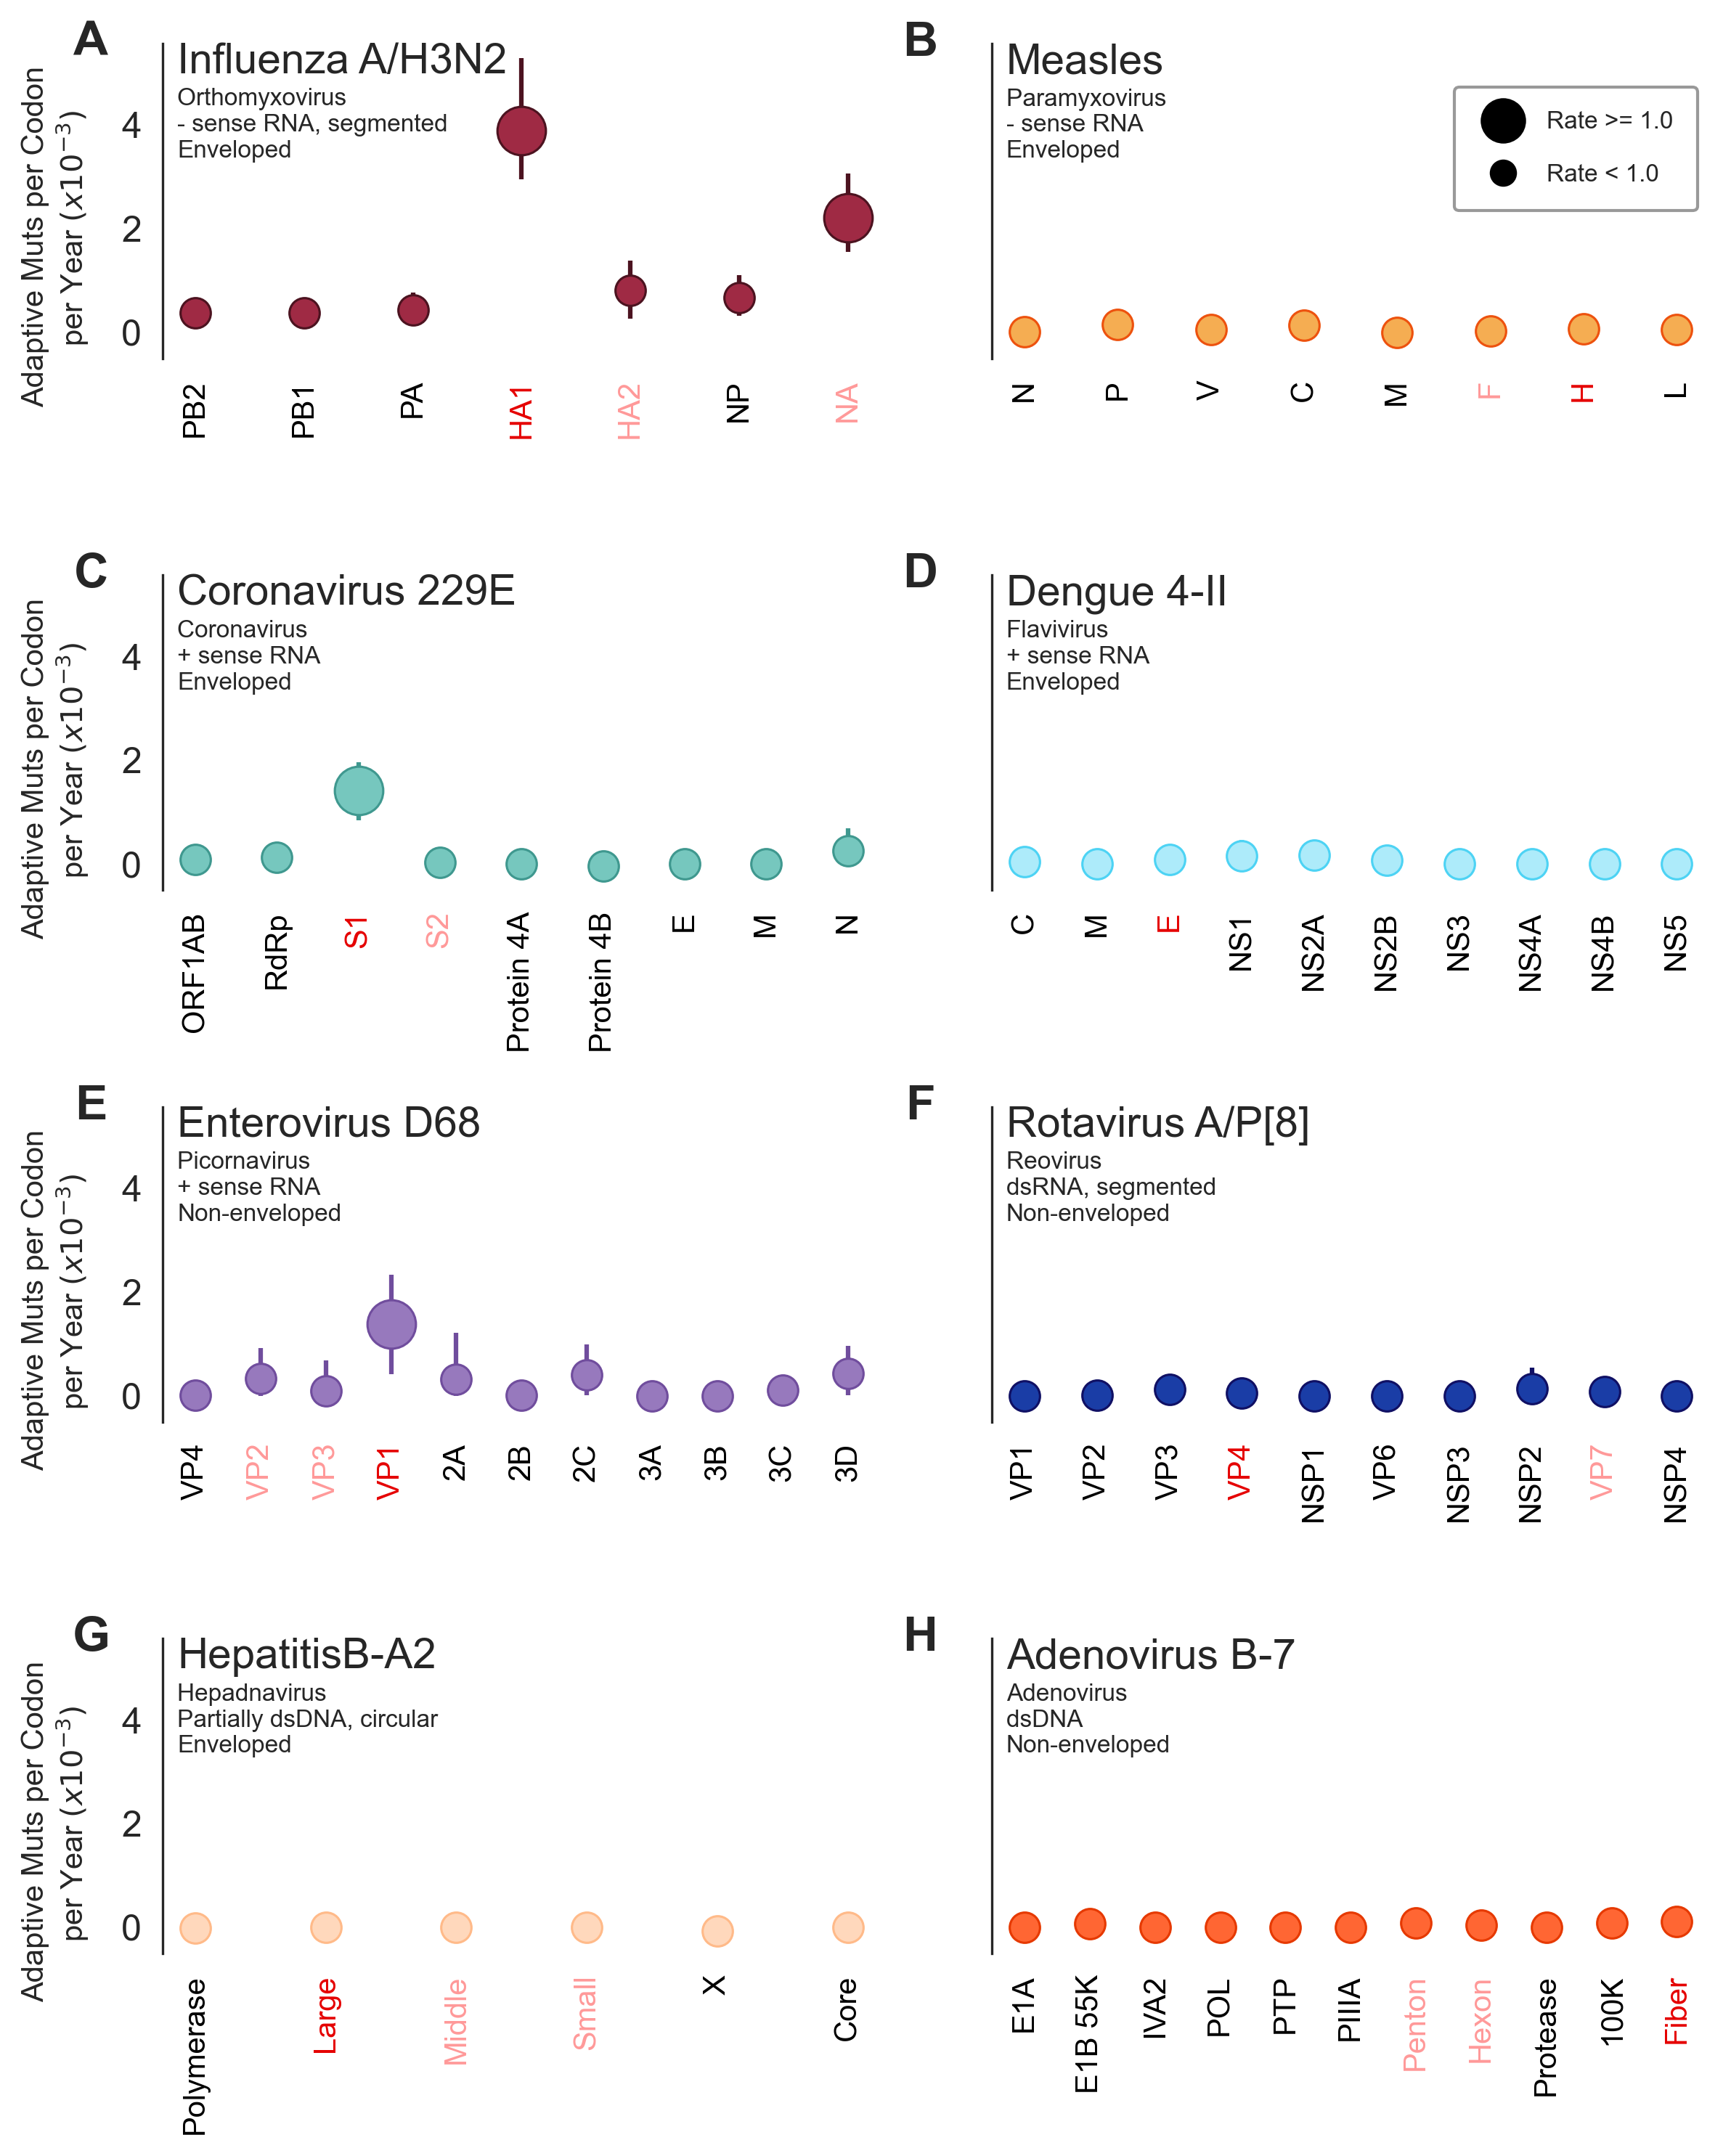

In [97]:
plot_rate_on_genome_cartoon(['h3n2', 'measles', '229e', 'dengue4_II', 
                             'enterovirusd68', 'rotavirusAg1p8', 'hepatitisB_A2', 'adenovirusB7'], 
                            filename = 'manuscript_figures/Figure3.png')

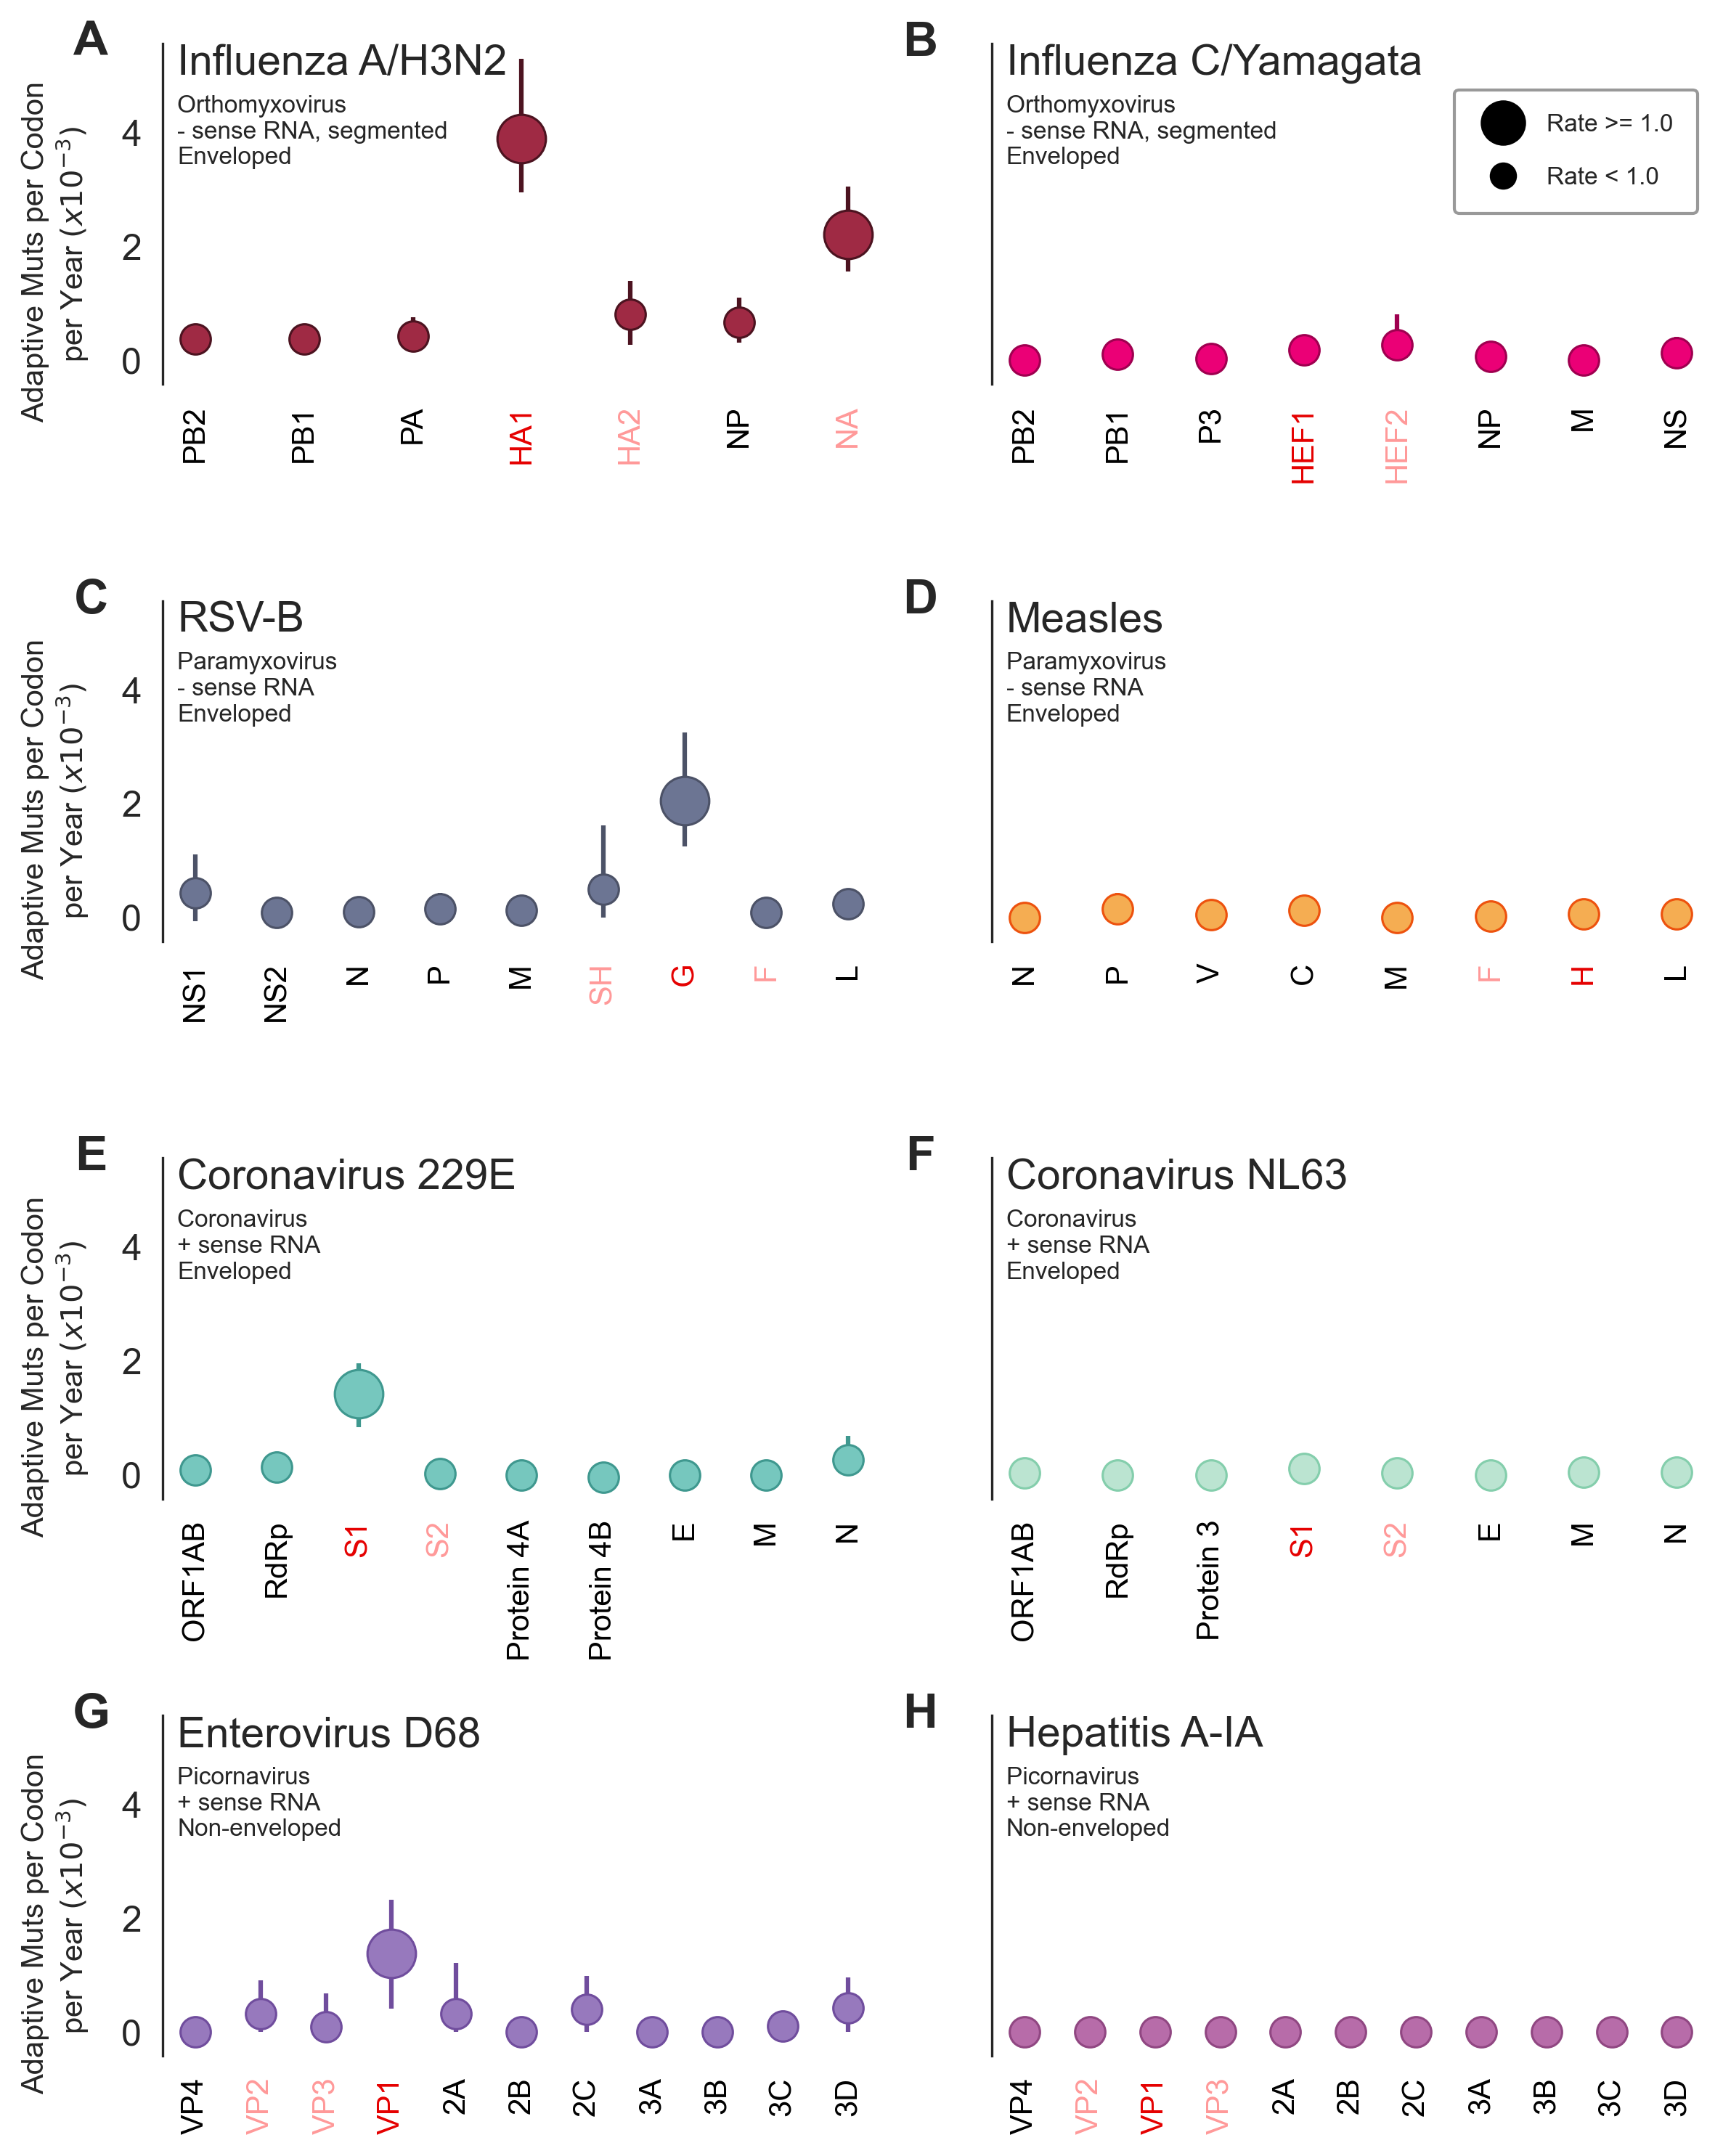

In [75]:
plot_rate_on_genome_cartoon(['h3n2', 'influenzaC_Yamagata', 'rsv_B', 'measles',
                             '229e', 'nl63', 'enterovirusd68', 'hepatitisA_IA'], 
                            filename = 'manuscript_figures/Figure3_option2.png')